In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
data_type = inspect(engine)
data_type.get_table_names()

['measurement', 'station']

In [12]:
#Get measurement table column names and data types
measurement_columns = data_type.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#Get station table column names and data types
station_columns = data_type.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

<function matplotlib.pyplot.show(*args, **kw)>

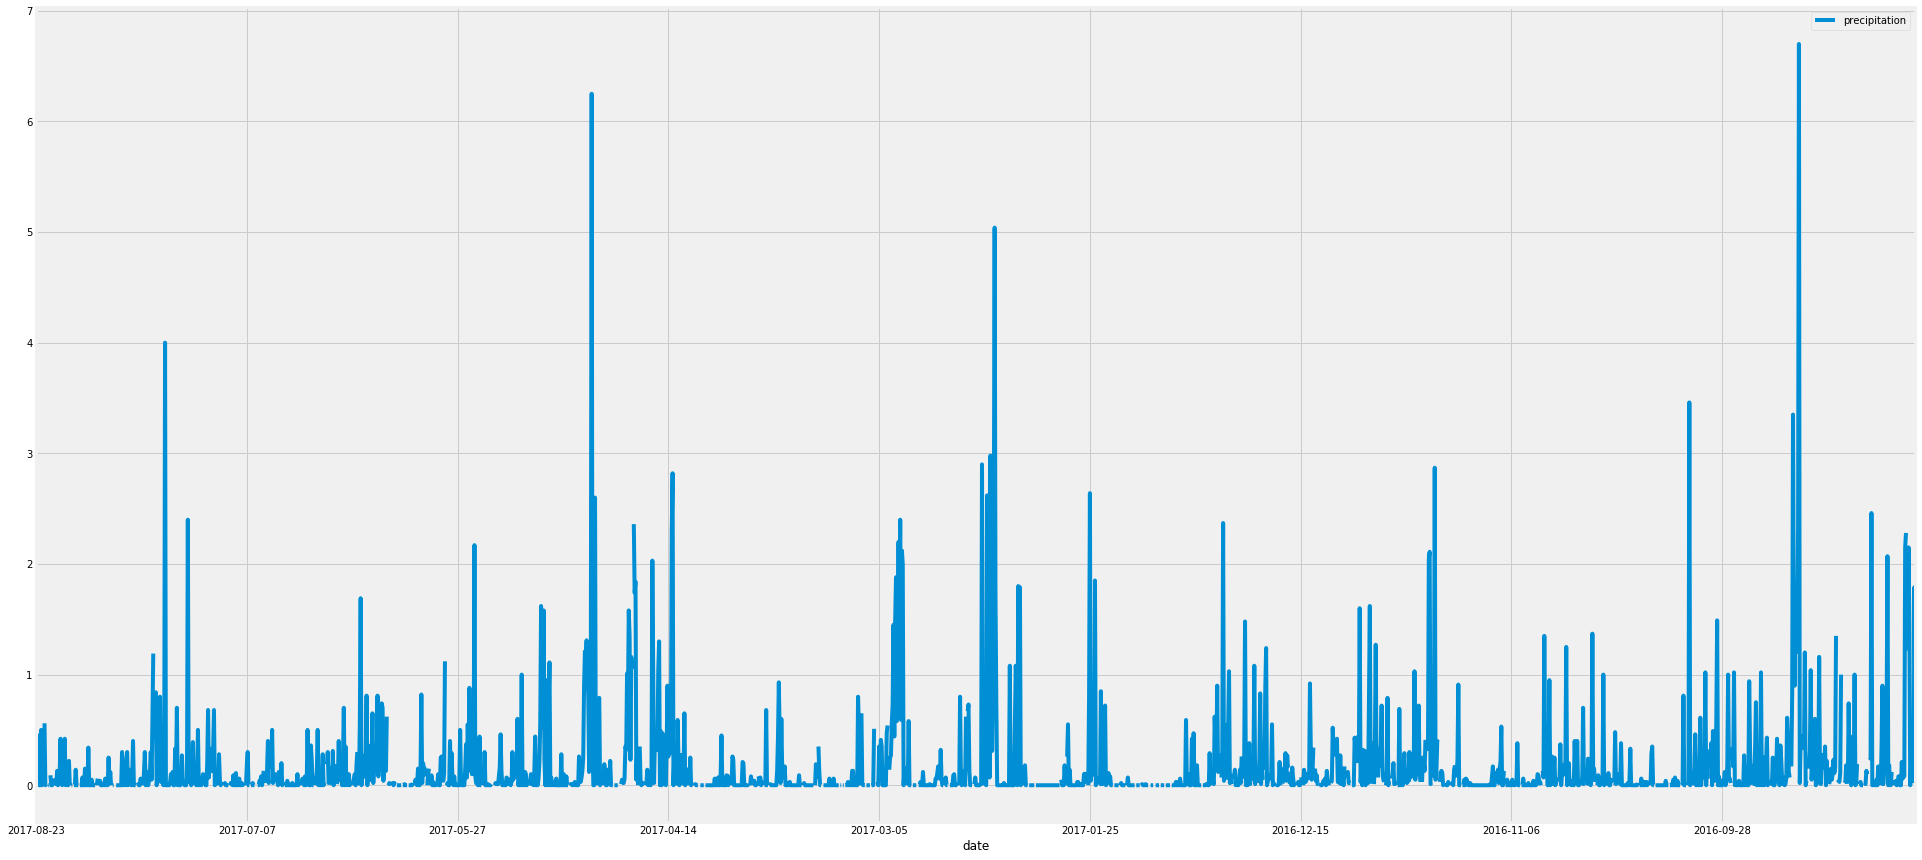

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
engine.execute('SELECT * FROM measurement').fetchall()
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print(query_date)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= dt.date(2016, 8, 23)).order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)
df

# Use Pandas to plot the data
df.plot(figsize=(30,15))
plt.show

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.tobs)]
func_temp = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
func_temp

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
func_temp = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
func_temp

[(54.0, 85.0, 71.66378066378067)]

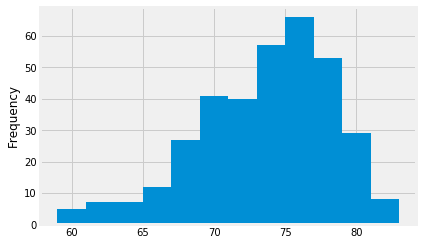

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date.desc()).all()
x = list(np.ravel(results))
plt.hist(x,bins=12)
plt.ylabel("Frequency")
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


Using the dates: 2012-02-28 to 2012-03-05:

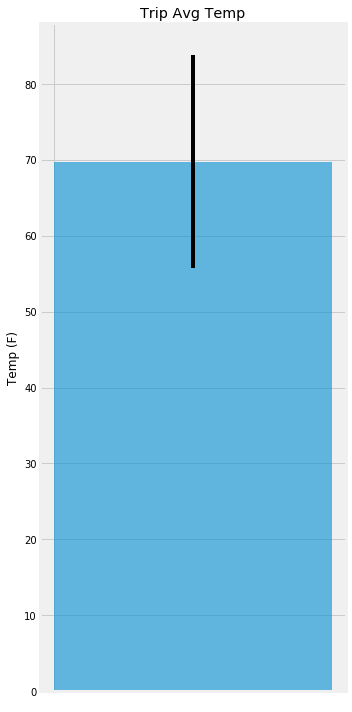

In [22]:
# Use the average temperature for the y value
tobs_avg = 69.75510204081633
x_axis = [0]
fig, ax  = plt.subplots(figsize=(5,10))

# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ax.bar(x_axis, tobs_avg,yerr=14, width=0.01,
       tick_label=[' '], align='edge',alpha=0.6)
plt.tight_layout()

# Plot the results from your previous query as a bar chart. 
plt.show()


In [24]:
start_date = dt.date(2012, 2, 28) - dt.timedelta(days=365)
print(start_date)

2011-02-28


In [25]:
end_date = dt.date(2012, 3, 5) - dt.timedelta(days=365)
print(end_date)

2011-03-06


In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).all()

[('USC00519397',
  157.14000000000004,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0)]